## パッケージのインポート

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split

## データセットを読み込みと正規化

In [2]:
path = 'data/datasets'

mnist_train = MNIST(path, train=True, download=True, transform=None)
train_x = mnist_train.data
train_y = mnist_train.targets

mnist_test = MNIST(path, train=False, download=True, transform=None)
test_x = mnist_test.data
test_y = mnist_test.targets

train_x = train_x / 255
test_x = test_x / 255

train_x = train_x.reshape(60000, 1, 28, 28)
test_x = test_x.reshape(10000, 1, 28, 28)

## データセットの確認

In [3]:
print('+++ MNIST data +++')
print(train_x.shape)
print(test_x.shape)

print('+++ MNIST label +++')
print(train_y.shape)
print(test_y.shape)


+++ MNIST data +++
torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
+++ MNIST label +++
torch.Size([60000])
torch.Size([10000])


## 学習用データセットとテスト用データセットを作成

In [4]:
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

## バッチサイズ分ずつデータを読み出すData Loaderを作成

In [5]:
train_batch = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1)

## ネットワークの構築

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=(0, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=(0, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

## CPUを使うのかGPUを使うのかを指定と確認

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)

print("Device: {}".format(device))

Device: cuda


## 損失関数と最適化関数の定義

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## ネットワークの構造の確認

In [9]:
print(net)

Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


## ニューラルネットを学習モードに設定

In [10]:
net.train()

Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

## loss(損失)とaccuracy(正解率)を保存するための空リストを作成

In [11]:
train_loss_list = []
train_accuracy_list = []

## 学習

In [12]:
epoch = 20

for i in range(epoch):
    print('-------------------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    train_loss = 0
    train_accuracy = 0

    net.train()

    for data, label in train_batch:
        data = data.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        y_pred_prob = net(data)
        loss = criterion(y_pred_prob, label)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        y_pred_label = torch.max(y_pred_prob, 1)[1]
        train_accuracy += torch.sum(y_pred_label == label).item() / len(label)

    batch_train_loss = train_loss / len(train_batch)
    batch_train_accuracy = train_accuracy / len(train_batch)

    print("Train Loss: {:.4f} Train Accuracy: {:.4f}".format(batch_train_loss, batch_train_accuracy))
    train_loss_list.append(batch_train_loss)
    train_accuracy_list.append(batch_train_accuracy)

-------------------------------------------------------
Epoch: 1/20
Train Loss: 0.2418 Train Accuracy: 0.9247
-------------------------------------------------------
Epoch: 2/20
Train Loss: 0.1039 Train Accuracy: 0.9692
-------------------------------------------------------
Epoch: 3/20
Train Loss: 0.0859 Train Accuracy: 0.9746
-------------------------------------------------------
Epoch: 4/20
Train Loss: 0.0735 Train Accuracy: 0.9788
-------------------------------------------------------
Epoch: 5/20
Train Loss: 0.0681 Train Accuracy: 0.9800
-------------------------------------------------------
Epoch: 6/20
Train Loss: 0.0633 Train Accuracy: 0.9818
-------------------------------------------------------
Epoch: 7/20
Train Loss: 0.0581 Train Accuracy: 0.9833
-------------------------------------------------------
Epoch: 8/20
Train Loss: 0.0581 Train Accuracy: 0.9831
-------------------------------------------------------
Epoch: 9/20
Train Loss: 0.0532 Train Accuracy: 0.9848
----------

## 実行結果をグラフ化

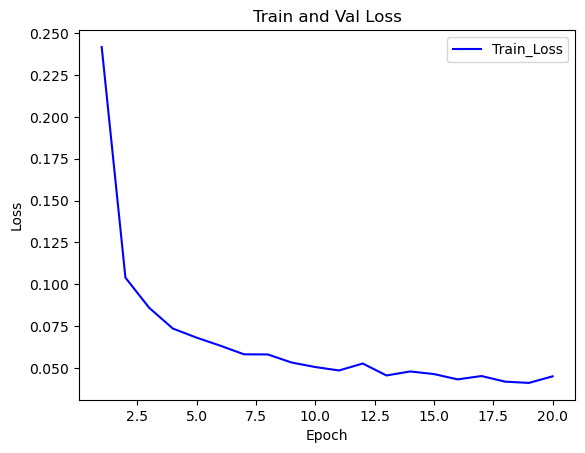

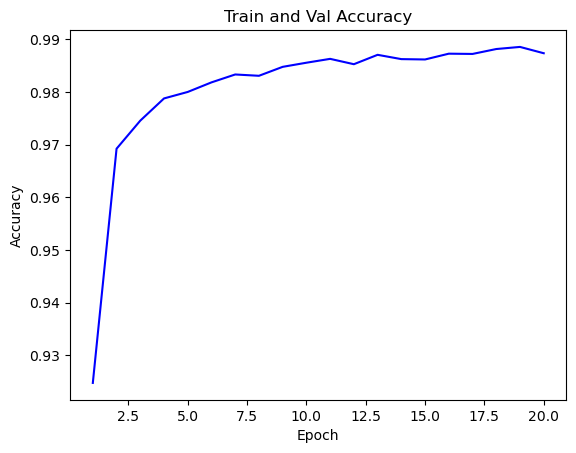

In [13]:
plt.figure()
plt.title('Train and Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue', linestyle="-", label='Train_Loss')
plt.legend()

plt.figure()
plt.title('Train and Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue', linestyle='-', label='Train_Accuracy')

plt.show()

## テストの実行

In [14]:
net.eval()
count = 0

for i in range(len(test_x)):
    data = torch.tensor(test_x[i], dtype=torch.float32)
    label = torch.tensor(test_y[i], dtype=torch.int64)

    data = data.reshape(1, 1, 28, 28)

    data = data.to(device)
    label = label.to(device)

    y_pred_prob = net(data)

    y_pred_prob = y_pred_prob.cpu().detach().numpy()

    y_pred_prob = y_pred_prob.reshape(10)
    max_value = max(y_pred_prob)

    for j in range(10):
        if y_pred_prob[j] == max_value:
            prediction_index = j
    print(f"test {i} : prediction : {prediction_index} ground_truth : {label}")

    if prediction_index == label:
        count += 1
print(f"accuracy : {count / len(test_x) * 100} %")

test 0 : prediction : 7 ground_truth : 7
test 1 : prediction : 2 ground_truth : 2
test 2 : prediction : 1 ground_truth : 1
test 3 : prediction : 0 ground_truth : 0
test 4 : prediction : 4 ground_truth : 4
test 5 : prediction : 1 ground_truth : 1
test 6 : prediction : 4 ground_truth : 4
test 7 : prediction : 9 ground_truth : 9
test 8 : prediction : 5 ground_truth : 5
test 9 : prediction : 9 ground_truth : 9
test 10 : prediction : 0 ground_truth : 0
test 11 : prediction : 6 ground_truth : 6
test 12 : prediction : 9 ground_truth : 9
test 13 : prediction : 0 ground_truth : 0
test 14 : prediction : 1 ground_truth : 1
test 15 : prediction : 5 ground_truth : 5
test 16 : prediction : 9 ground_truth : 9
test 17 : prediction : 7 ground_truth : 7
test 18 : prediction : 3 ground_truth : 3
test 19 : prediction : 4 ground_truth : 4
test 20 : prediction : 9 ground_truth : 9
test 21 : prediction : 6 ground_truth : 6
test 22 : prediction : 6 ground_truth : 6
test 23 : prediction : 5 ground_truth : 5
te

/tmp/ipykernel_54462/1800750676.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(test_x[i], dtype=torch.float32)
/tmp/ipykernel_54462/1800750676.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(test_y[i], dtype=torch.int64)


test 89 : prediction : 1 ground_truth : 1
test 90 : prediction : 3 ground_truth : 3
test 91 : prediction : 6 ground_truth : 6
test 92 : prediction : 9 ground_truth : 9
test 93 : prediction : 3 ground_truth : 3
test 94 : prediction : 1 ground_truth : 1
test 95 : prediction : 4 ground_truth : 4
test 96 : prediction : 1 ground_truth : 1
test 97 : prediction : 7 ground_truth : 7
test 98 : prediction : 6 ground_truth : 6
test 99 : prediction : 9 ground_truth : 9
test 100 : prediction : 6 ground_truth : 6
test 101 : prediction : 0 ground_truth : 0
test 102 : prediction : 5 ground_truth : 5
test 103 : prediction : 4 ground_truth : 4
test 104 : prediction : 9 ground_truth : 9
test 105 : prediction : 9 ground_truth : 9
test 106 : prediction : 2 ground_truth : 2
test 107 : prediction : 1 ground_truth : 1
test 108 : prediction : 9 ground_truth : 9
test 109 : prediction : 4 ground_truth : 4
test 110 : prediction : 8 ground_truth : 8
test 111 : prediction : 7 ground_truth : 7
test 112 : prediction 